<a href="https://colab.research.google.com/github/warninjaden/Neural-Networks-Project/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [2]:
if not os.path.exists('./asian2noasian'):
  import gdown
  url = 'https://drive.google.com/uc?export=download&id=1Q3m1VEmGfA55OBjqh8tIoFWUYmvS-874'
  gdown.download(url, './asian2noasian.zip', quiet=False)
  !unzip ./asian2noasian.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?export=download&id=1Q3m1VEmGfA55OBjqh8tIoFWUYmvS-874
To: /content/asian2noasian.zip
100%|██████████| 27.6M/27.6M [00:00<00:00, 177MB/s]


In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [4]:
import shutil, sys 
shutil.move("/content/asian2noasian/trainA", "/content/noasian_train/A")
shutil.move("/content/asian2noasian/trainB", "/content/asian_train/B")
shutil.move("/content/asian2noasian/testA", "/content/noasian_test/A")
shutil.move("/content/asian2noasian/testB", "/content/asian_test/B")

'/content/asian_test/B'

torch.Size([5, 3, 256, 256])


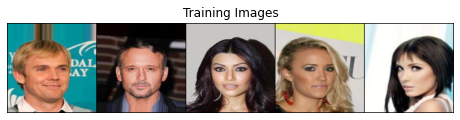

In [5]:
bs = 5
workers = 2
image_size = (256,256)
dataroot = 'noasian_train/'
dataset_noasians_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_train_noasians = torch.utils.data.DataLoader(dataset_noasians_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_train_noasians))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

torch.Size([5, 3, 256, 256])


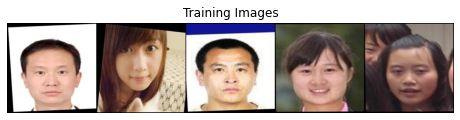

In [6]:
bs = 5
workers = 2
image_size = (256,256)
dataroot = 'asian_train/'
dataset_asians_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_train_asians = torch.utils.data.DataLoader(dataset_asians_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_train_asians))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

torch.Size([5, 3, 256, 256])


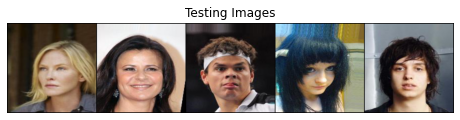

In [7]:
bs = 5
workers = 2
image_size = (256,256)
dataroot = 'noasian_test/'
dataset_noasians_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_noasians = torch.utils.data.DataLoader(dataset_noasians_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_noasians))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

torch.Size([5, 3, 256, 256])


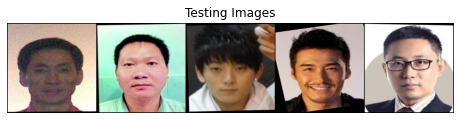

In [8]:
bs = 5
workers = 2
image_size = (256,256)
dataroot = 'asian_test/'
dataset_asians_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_asians = torch.utils.data.DataLoader(dataset_asians_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_asians))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
def plot_images_test(dataloader_test_horses, dataloader_zebra_test): 
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()


    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real No asians")
    plt.show()

          
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake Asians")
    plt.show()


    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real Asians")
    plt.show()


    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake No asians")
    plt.show()

In [10]:
def plot_all_images(image_number, dataloader_test_horses, dataloader_zebra_test): 
    #generate fake Asians
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real No asians")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake Asians")
    plt.show()
    #generate fake No asians
    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real Asians")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake No asians")
    plt.show()
    #identity 
    identity_a_test=G_B2A(batch_a_test.cuda() ).cpu().detach()
    identity_b_test=G_A2B(batch_b_test.cuda() ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity No asians")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity Asians")
    plt.show()
    #recovered image
    recover_a_test=G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered No asians")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered Asians")
    plt.show()

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, "/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_G_A2B.pt")
  torch.save(G_B2A, "/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_G_B2A.pt")
  torch.save(D_A, "/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_D_A.pt")
  torch.save(D_B, "/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_D_B.pt")

def load_models( name):

  G_A2B=torch.load("/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_G_A2B.pt")
  G_B2A=torch.load("/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_G_B2A.pt")
  D_A=torch.load("/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_D_A.pt")
  D_B=torch.load("/content/gdrive/My Drive/cycleGAN_modelos/"+name+"_D_B.pt")
  return G_A2B, G_B2A, D_A, D_B

In [13]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

In [14]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

In [15]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [16]:
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Optimizers

In [17]:
import gc


def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):

    # For each batch in the dataloader
    for  i,(data_noasians, data_asians) in enumerate(zip(dataloader_train_noasians, dataloader_train_asians),0):
    
        # Set model input
        a_real = data_noasians[0].to(device)
        b_real = data_asians[0].to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

        # Genrated images
        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)


        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # Fool discriminator
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses

        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del data_asians, data_noasians, a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(dataloader_test_noasians, dataloader_test_asians)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

Starting Training Loop...
[1/20]	FDL_A2B: 0.5530	FDL_B2A: 0.4927	CL_A: 0.4043	CL_B: 0.4123	ID_B2A: 0.6297	ID_A2B: 0.6261	Loss_D_A: 0.5099	Loss_D_A: 0.3603
[1/20]	FDL_A2B: 0.3777	FDL_B2A: 0.2728	CL_A: 0.3350	CL_B: 0.2799	ID_B2A: 0.4992	ID_A2B: 0.3919	Loss_D_A: 0.3993	Loss_D_A: 0.2701


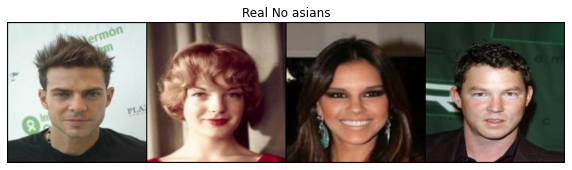

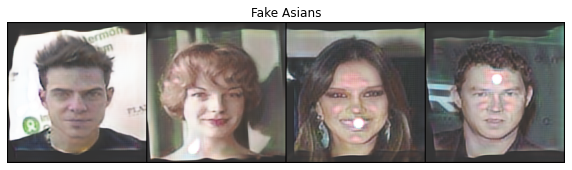

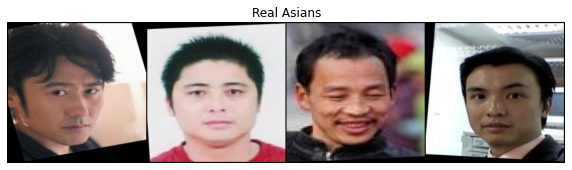

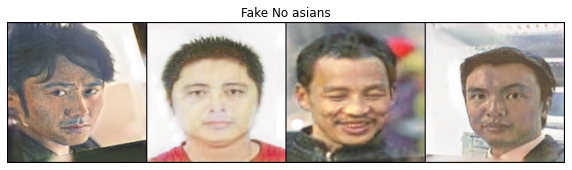

[2/20]	FDL_A2B: 0.4663	FDL_B2A: 0.4422	CL_A: 0.2847	CL_B: 0.3803	ID_B2A: 0.3790	ID_A2B: 0.5470	Loss_D_A: 0.5359	Loss_D_A: 0.5683
[2/20]	FDL_A2B: 0.3441	FDL_B2A: 0.2698	CL_A: 0.3057	CL_B: 0.3257	ID_B2A: 0.3869	ID_A2B: 0.5594	Loss_D_A: 0.2523	Loss_D_A: 0.1650
[3/20]	FDL_A2B: 0.3896	FDL_B2A: 0.3285	CL_A: 0.3196	CL_B: 0.3417	ID_B2A: 0.4911	ID_A2B: 0.4819	Loss_D_A: 0.4837	Loss_D_A: 0.3927
[3/20]	FDL_A2B: 0.4081	FDL_B2A: 0.2846	CL_A: 0.3391	CL_B: 0.3053	ID_B2A: 0.5634	ID_A2B: 0.5138	Loss_D_A: 0.3043	Loss_D_A: 0.3336
[4/20]	FDL_A2B: 0.5434	FDL_B2A: 0.4193	CL_A: 0.3431	CL_B: 0.3332	ID_B2A: 0.5556	ID_A2B: 0.5678	Loss_D_A: 0.3668	Loss_D_A: 0.3664
[4/20]	FDL_A2B: 0.0994	FDL_B2A: 0.3491	CL_A: 0.3101	CL_B: 0.3569	ID_B2A: 0.4747	ID_A2B: 0.7452	Loss_D_A: 0.4596	Loss_D_A: 0.4624
[5/20]	FDL_A2B: 0.5006	FDL_B2A: 0.5141	CL_A: 0.2930	CL_B: 0.5330	ID_B2A: 0.4094	ID_A2B: 0.6094	Loss_D_A: 0.3528	Loss_D_A: 0.4616
[5/20]	FDL_A2B: 0.2683	FDL_B2A: 0.2835	CL_A: 0.2999	CL_B: 0.3235	ID_B2A: 0.4954	ID_A2B: 0.3712	Lo

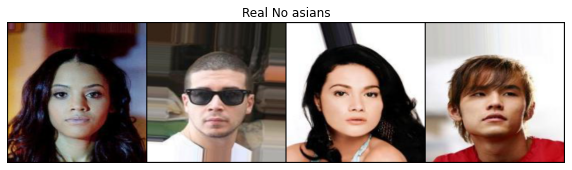

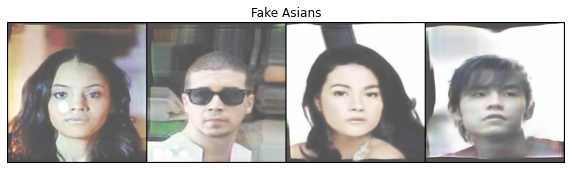

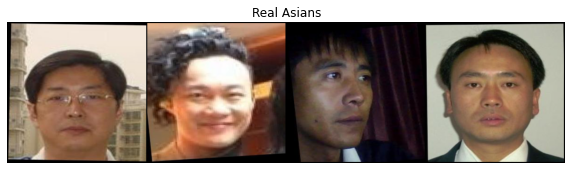

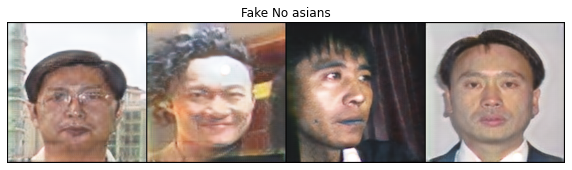

In [ ]:
name="training50"
G_A2B, G_B2A, D_A, D_B = load_models(name)

epochs=20
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)


In [ ]:
name="training50"
